# ARIMA with statsmodels and predicting future outcomes

## Analyse the dataset and fix it accordingly

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')

In [3]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [4]:
df.columns = ['Month', "Milk in pounds per cow"]

In [5]:
df.drop(168, axis = 0, inplace=True)

In [6]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

In [7]:
df.head()

,Milk in pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [8]:
df.describe()

,Milk in pounds per cow
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


## Plot the dataset, observe overall trend using MA

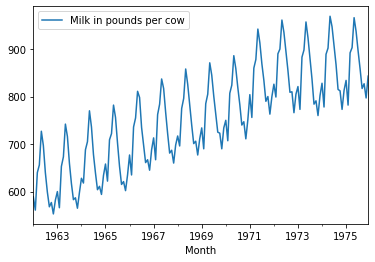

In [9]:
df.plot()

In [10]:
time_series = df['Milk in pounds per cow']

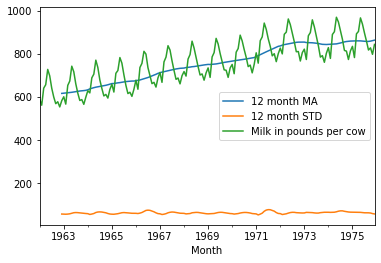

In [11]:
time_series.rolling(12).mean().plot(label='12 month MA')
time_series.rolling(12).std().plot(label='12 month STD')
time_series.plot()
plt.legend()

## Decompose seasonality

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [13]:
decomp = seasonal_decompose(time_series)

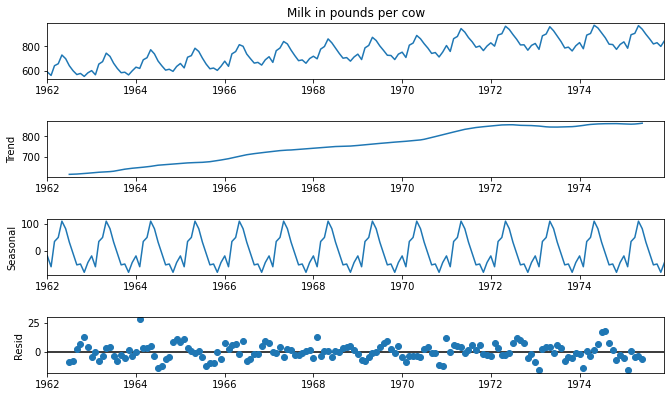

In [14]:
fig = decomp.plot()
fig.set_size_inches(10, 6)

## Use Dickey Fuller for checking stationarity

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
result = adfuller(time_series)

In [17]:
def adf_check(time_series):
    result = adfuller(time_series)
    print("Augmented Dickey Fuller")
    labels = ['ADF Dickey-Fuller Test', 'p-value', '# of lags', 'Num of obs used']
    for value, label in zip(result, labels):
        print(label+ " : "+str(value))
    
    if result[1] <= 0.05:
        print('Strong evidence against null hypothesis')
        print('reject null hypothesis')
        print('Data has no unit root and is stationary')
    else:
        print('Weak evidence against null hypothesis')
        print('Fail to reject null hypothesis')
        print('Data has a unit root and is non stationary')

In [18]:
adf_check(time_series)

Augmented Dickey Fuller
ADF Dickey-Fuller Test : -1.3038115874221348
p-value : 0.6274267086030292
# of lags : 13
Num of obs used : 154
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root and is non stationary


In [19]:
df['First difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(1)

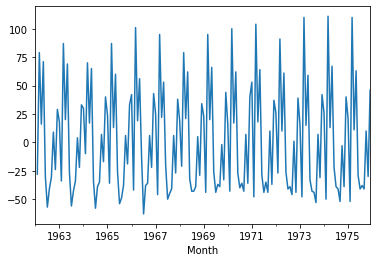

In [20]:
df['First difference'].plot()

In [21]:
adf_check(df['First difference'].dropna())

Augmented Dickey Fuller
ADF Dickey-Fuller Test : -3.0549955586530744
p-value : 0.030068004001785296
# of lags : 14
Num of obs used : 152
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


In [22]:
df['Seasonal Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(12)

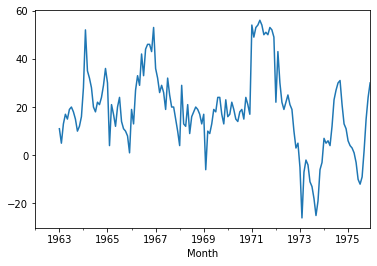

In [23]:
df['Seasonal Difference'].plot()

In [24]:
adf_check(df['Seasonal Difference'].dropna())

Augmented Dickey Fuller
ADF Dickey-Fuller Test : -2.3354193143593975
p-value : 0.16079880527711365
# of lags : 12
Num of obs used : 143
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root and is non stationary


In [25]:
df['Seasonal First Difference'] = df['First difference'] - df['First difference'].shift(12)

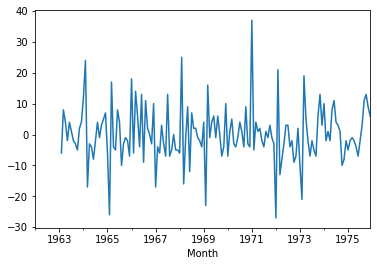

In [26]:
df['Seasonal First Difference'].plot()

In [27]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dickey Fuller
ADF Dickey-Fuller Test : -5.038002274921962
p-value : 1.865423431879022e-05
# of lags : 11
Num of obs used : 143
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


## Plot autocorrelation and partial autocorrelation plots

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

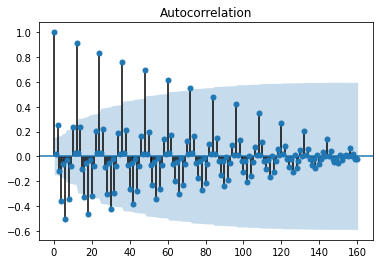

In [29]:
fig_first = plot_acf(df['First difference'].dropna(), lags=160)

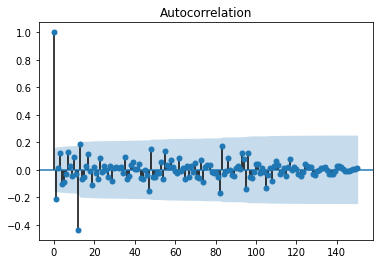

In [30]:
fig_seasonal_first = plot_acf(df['Seasonal First Difference'].dropna(), lags=150)

In [31]:
from pandas.plotting import autocorrelation_plot

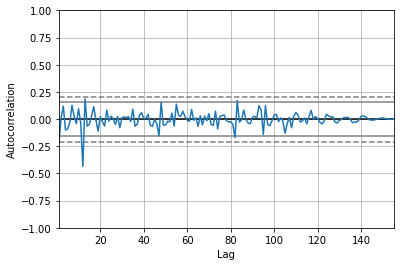

In [32]:
autocorrelation_plot(df['Seasonal First Difference'].dropna())

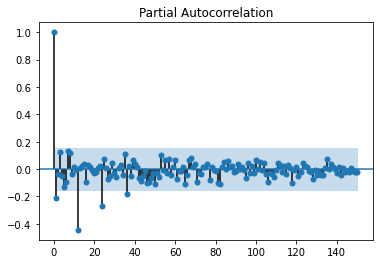

In [33]:
pacf = plot_pacf(df['Seasonal First Difference'].dropna(), lags=150, method='ywm')

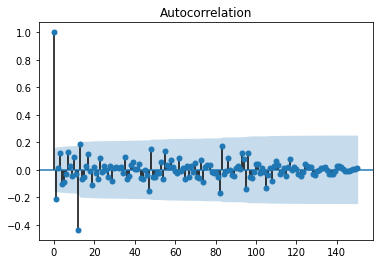

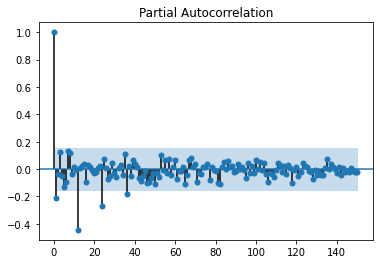

In [34]:
fig1=plot_acf(df['Seasonal First Difference'].dropna(), lags=150)
fig2=plot_pacf(df['Seasonal First Difference'].dropna(), lags=150, method='ywm')

## Use ARIMA

### Use the order from ACF and PACF in SARIMAX

In [35]:
from statsmodels.tsa.arima_model import ARIMA

In [36]:
model=sm.tsa.statespace.SARIMAX(df['Milk in pounds per cow'], order=(0,1,0), seasonal_order=(1,1,1,12))

C:\Users\souvi\AppData\Local\Programs\Python\Python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\souvi\AppData\Local\Programs\Python\Python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [37]:
results = model.fit()

In [38]:
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:               Milk in pounds per cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -534.065
Date:                              Tue, 28 Apr 2020   AIC                           1074.131
Time:                                      11:48:24   BIC                           1083.261
Sample:                                  01-01-1962   HQIC                          1077.839
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.58

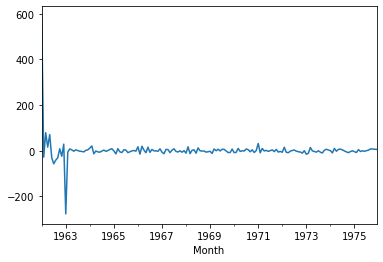

In [39]:
results.resid.plot()

### Residue should be as close to zero as possible

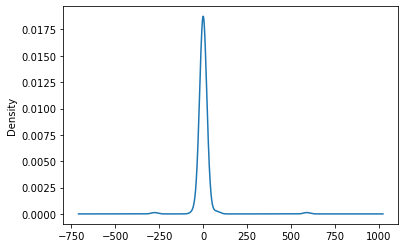

In [40]:
results.resid.plot(kind='kde')

### Check for overlap between forecast and existing data

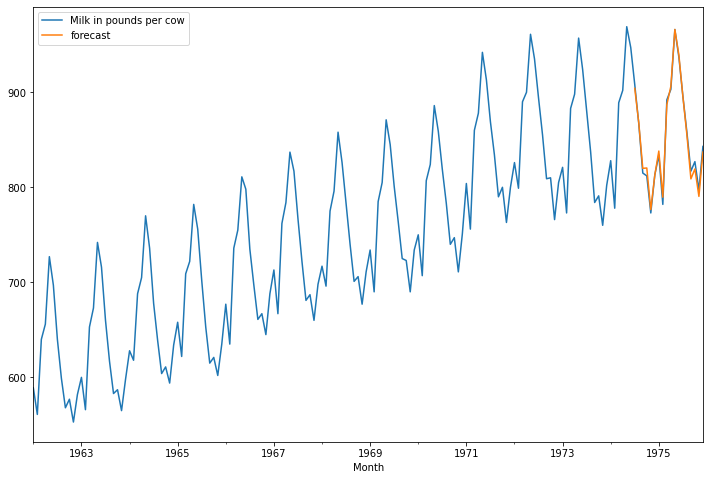

In [41]:
df['forecast'] = results.predict(start=150, end=168)
df[['Milk in pounds per cow', 'forecast']].plot(figsize=(12,8))

### Add more time stamps for extrapolating data

In [42]:
from pandas.tseries.offsets import DateOffset

In [43]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1, 360)]

In [44]:
df.index[-1]

Timestamp('1975-12-01 00:00:00')

In [45]:
future_dates

[Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00'),
 Timestamp('1977-12-01 00:00:00'),
 Timestamp('1978-01-01 00:00:00'),
 Timestamp('1978-02-01 00:00:00'),
 Timestamp('1978-03-01 00:00:00'),
 Timestamp('1978-04-01 00:00:00'),
 Timestamp('1978-05-

In [46]:
future_df=pd.DataFrame(index=future_dates, columns=df.columns)

In [47]:
future_df

,Milk in pounds per cow,First difference,Seasonal Difference,Seasonal First Difference,forecast
1976-01-01,NaN,NaN,NaN,NaN,NaN
1976-02-01,NaN,NaN,NaN,NaN,NaN
1976-03-01,NaN,NaN,NaN,NaN,NaN
1976-04-01,NaN,NaN,NaN,NaN,NaN
1976-05-01,NaN,NaN,NaN,NaN,NaN
1976-06-01,NaN,NaN,NaN,NaN,NaN
1976-07-01,NaN,NaN,NaN,NaN,NaN
1976-08-01,NaN,NaN,NaN,NaN,NaN
1976-09-01,NaN,NaN,NaN,NaN,NaN
1976-10-01,NaN,NaN,NaN,NaN,NaN


In [48]:
final_df = pd.concat([df, future_df])

In [49]:
final_df.head()

,Milk in pounds per cow,First difference,Seasonal Difference,Seasonal First Difference,forecast
1962-01-01,589.0,NaN,NaN,NaN,NaN
1962-02-01,561.0,-28.0,NaN,NaN,NaN
1962-03-01,640.0,79.0,NaN,NaN,NaN
1962-04-01,656.0,16.0,NaN,NaN,NaN
1962-05-01,727.0,71.0,NaN,NaN,NaN


In [50]:
final_df.tail()

,Milk in pounds per cow,First difference,Seasonal Difference,Seasonal First Difference,forecast
2005-07-01,NaN,NaN,NaN,NaN,NaN
2005-08-01,NaN,NaN,NaN,NaN,NaN
2005-09-01,NaN,NaN,NaN,NaN,NaN
2005-10-01,NaN,NaN,NaN,NaN,NaN
2005-11-01,NaN,NaN,NaN,NaN,NaN


In [51]:
final_df['forecast']=results.predict(start=168,end=528)

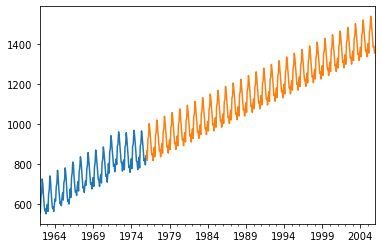

In [52]:
final_df['Milk in pounds per cow'].plot()
final_df['forecast'].plot()

In [53]:
final_df.tail()

,Milk in pounds per cow,First difference,Seasonal Difference,Seasonal First Difference,forecast
2005-07-01,NaN,NaN,NaN,NaN,1467.870577
2005-08-01,NaN,NaN,NaN,NaN,1428.260421
2005-09-01,NaN,NaN,NaN,NaN,1382.212470
2005-10-01,NaN,NaN,NaN,NaN,1387.348779
2005-11-01,NaN,NaN,NaN,NaN,1353.276270
